In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as sp

import torch

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

import sys
import os
import pickle



### load model specs

In [3]:
from sbmi.graph_prior.additive_model.model_specs import additivemodel

### example sampling

[  0   4   3   2 103  -1]
[{}, {'c_1': 2.81497836768255, 'c_2': 1.7374665875448134}, {'c_1': -0.05303021021802601}, {'c_1': 1.326185760938647}, {'c_1': 1.7937078705150578}, {}]


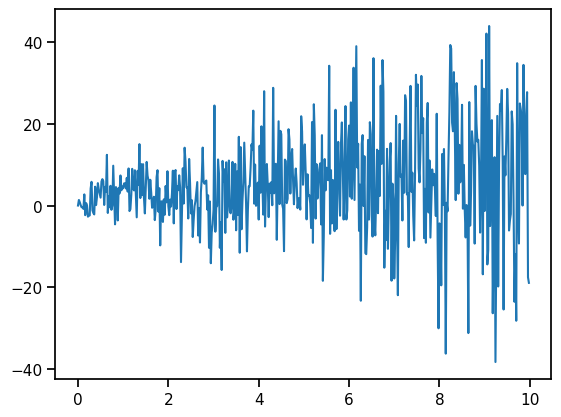

In [5]:
sns.set_context("notebook")
model = additivemodel.sample_model(max_len_token=20)
model_inds = model.model_ind  # [valid_inds[0]:valid_inds[1]]
constants = model.constants  # [valid_inds[0]:valid_inds[1]]
x, y = model.run_model()

print(model_inds)
print(constants)

plt.plot(x, y[0])

In [6]:
# total number of parameters
additivemodel.total_params

7

In [7]:
# node prior bounds
additivemodel.node_prior_bounds

tensor([[-2.0000, -2.0000, -0.5000,  0.0000,  0.5000,  0.1000,  0.5000],
        [ 2.0000,  2.0000,  0.5000,  5.0000,  5.0000,  2.0000,  2.0000]])

In [8]:
# partition of parameters
additivemodel.theta_partition

tensor([1, 1, 1, 2, 1, 1])

In [9]:
# check negatively coupled nodes
additivemodel.model_graph.neg_coupling

{1: [2], 2: [1], 3: [], 4: [], 100: [], 103: []}

-0.053030210218026*x_1**2 + 1.32618576093865*x_1 + 2.81497836768255*sin(1.73746658754481*x_1)


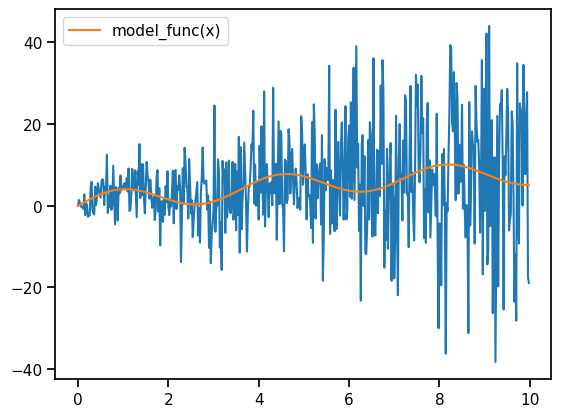

In [11]:
# check the example sample
# with and without noise
print(model.formula)

plt.plot(x[:1000], y[0, :1000])
plt.plot(x, model.model_func(x), label="model_func(x)")


plt.legend()

## Get a trainingsdataset

In [14]:
from sbmi.data_handling import (
    sort_model_components_constants,
    transform_model_inds,
    prepare_constants,
    flatten_theta,
    get_dataset,
)
from sbmi.graph_prior.utils import calc_model_prior_sample

In [15]:
 # get raw dataset
 n = 5_000
 valid_inds=[1,-1]
model_inds, constants, t,y = get_dataset(additivemodel,
                                         n=n, 
                                         valid_inds=valid_inds, 
                                         sort=False, 
                                         max_len_token=20)

y = y.squeeze()

partition = additivemodel.theta_partition



# post process 

n_components = len(additivemodel.theta_partition)

model_inds, constants = sort_model_components_constants(model_inds, constants)

t = torch.tensor(t, dtype=torch.double)
y = torch.tensor(y, dtype=torch.double)
transformed_model_inds = transform_model_inds(model_inds)
model_data = prepare_constants(transformed_model_inds, constants, n_components=n_components, max_params=2)

binary_model = torch.tensor(model_data[:,:,0])

theta = torch.tensor(model_data[:,:,1:])

theta = flatten_theta(theta, partition)

#y = torch.tensor(y)

In [16]:
y.shape

torch.Size([5000, 500])

In [17]:
## calculate sample model prior

p, ms = calc_model_prior_sample(binary_model, ordered=True)

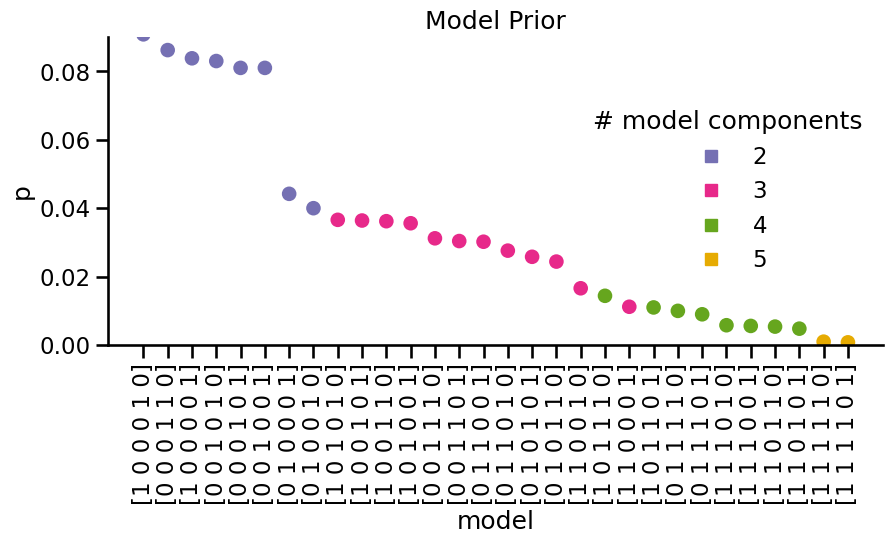

number of different models: torch.Size([30])


In [22]:
colors = plt.cm.Dark2

sns.set_context("talk")

plt.figure(1, figsize=(10, 4))

plt.title("Model Prior")
plt.scatter(
    np.arange(p.shape[0]),
    np.array(p),
    color=[colors(i) for i in np.array(ms.sum(1))],
)
plt.ylim(0, 0.09)

plt.xticks(
    ticks=np.arange(p.shape[0]),
    labels=np.array(ms),
    # labels= np.array([np.array(model_tokens)[np.array(ms[i], dtype=bool)]
    #                 for i in range(p.shape[0])],
    #               dtype=object),
    rotation=90,
)

sns.despine()
plt.ylabel("p")
plt.xlabel("model")

f = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none")[0]
handles = [f("s", colors(i)) for i in range(2, 6)]
labels = ["2", "3", "4", "5"]
legend = plt.legend(
    handles, labels, loc=5, framealpha=1, frameon=False, title="# model components"
)
plt.show()

print("number of different models:", p.shape)

In [23]:
additivemodel.model_dict

{1: 'c_1*x_1',
 2: 'c_1*x_1',
 3: 'c_1*x_1*x_1',
 4: 'c_1*sin(c_2*x_1)',
 100: 'observer_noise',
 103: 'increasing_noise'}

In [24]:
model_tokens = ["l1", "l2", "q", "sin", "n1", "n2"]

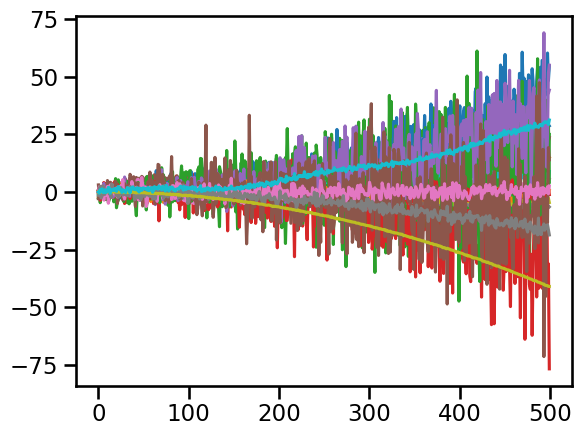

In [27]:
for i in range(20):
    plt.plot(y[i])

#### reconstruct model from dataset

In [29]:
from sbmi.data_handling import compile_and_run_model

In [30]:
i = 5
model_ind_raw = binary_model[i]
constants_1_raw = theta[i]
print(model_ind_raw)
print(constants_1_raw)

tensor([1., 0., 1., 1., 1., 0.], dtype=torch.float64)
tensor([0.4335,    nan, 0.1526, 4.9867, 1.3414, 1.1607,    nan],
       dtype=torch.float64)


In [31]:
t_test, y_test, model_rebuild = compile_and_run_model(
    additivemodel,
    model_ind_raw,
    constants_1_raw,
    additivemodel.model_dict.keys(),
    partition,
    return_model=True,
    verbose=True,
)

given predictions:
model inds : [  1   3   4 100]
model constants: [{'c_1': 0.43354135751724243}, {'c_1': 0.15258528292179108}, {'c_1': 4.986652851104736, 'c_2': 1.341406226158142}, {'c_1': 1.160652995109558}]
predicted formula:  0.153*x_1**2 + 0.434*x_1 + 4.987*sin(1.341*x_1)


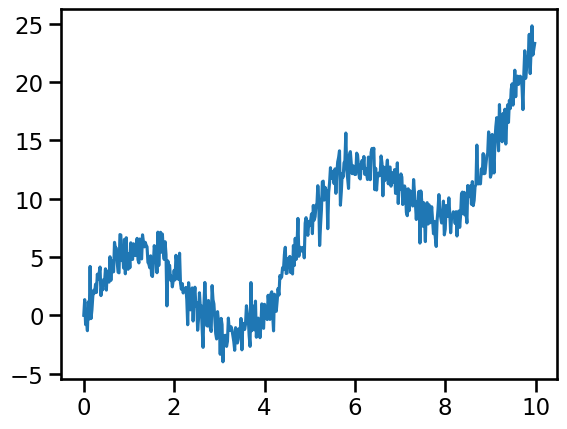

In [32]:
plt.plot(t_test, y_test)
# plt.plot(t,y[i])

In [33]:
model_rebuild.formula

0.152585282921791*x_1**2 + 0.433541357517242*x_1 + 4.98665285110474*sin(1.34140622615814*x_1)

#### build a new model



In [34]:
additivemodel.node_prior_bounds

tensor([[-2.0000, -2.0000, -0.5000,  0.0000,  0.5000,  0.1000,  0.5000],
        [ 2.0000,  2.0000,  0.5000,  5.0000,  5.0000,  2.0000,  2.0000]])

1.0*x_1 + 4.0*sin(5.0*x_1)


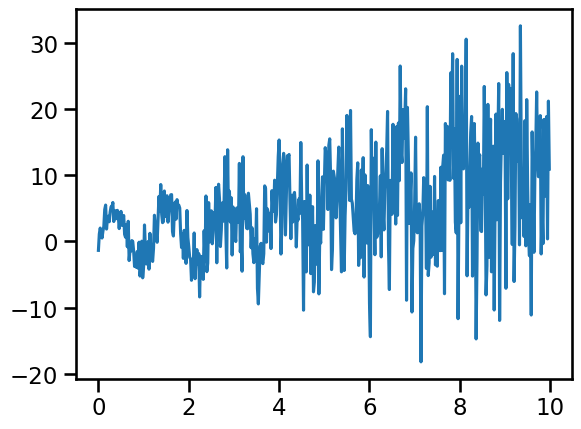

In [35]:
partition = additivemodel.theta_partition
model_ind_new = torch.tensor([1, 0, 0, 1, 0, 1])
constants_new = torch.tensor([1, torch.nan, torch.nan, 4, 5, 2, 1])

t_test, y_test, model_rebuild = compile_and_run_model(
    additivemodel,
    model_ind_new,
    constants_new,
    additivemodel.model_dict.keys(),
    partition,
    return_model=True,
)

plt.plot(t_test, y_test)
print(model_rebuild.formula)